In [51]:
%store -r import_all_libs

In [52]:
import_all_libs

In [53]:
width, height = 30, 10 # example with 15x6 inches
plt.rcParams['figure.figsize'] = [width, height]
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

# NRC Analysis

Análise de dados do Nike Run Club

In [61]:
from os import listdir
from os.path import isfile, join
import json
from datetime import datetime

# reads files from this folder
path = '/home/tuts/health_data/activities/'
files = [f for f in listdir(path) if isfile(join(path, f))]

In [62]:
data = list()
for file in files:
    # loads json files into a list
    file_path = f'/home/tuts/health_data/activities/{file}'
    data.append(json.load(open(f'{file_path}',"rb")))

### Etapa de leitura dos dados

Os dados estão em formato json.

In [63]:
df = pd.DataFrame()
for d in data:
    normalized_d = pd.json_normalize(d)
        
    normalized_d_filtered = normalized_d[['summaries', 'tags.location', 'metrics']]
    
    # summary contains entry metric values
    prov = pd.json_normalize(normalized_d_filtered.summaries[0])
    
    # get the unit for a metric
    metric = {
        'distance': 'KM',
        'steps': 'N',
        'speed': 'KMH',
        'calories': 'KCAL',
        'heart_rate': 'BPM',
        'pace': 'MKM',
        'nikefuel': 'FUEL',
        'rpe': 'RATING',
        'ascent': 'M',
        'descent': 'M'
    }
    
    prov['metric_all'] = prov.metric+'_'+prov.summary+'_'+prov.metric.apply(lambda x: metric.get(x))
    
    final = prov[['metric_all', 'value']].T
    final = final.reset_index(drop=True)
    final.columns = final.iloc[0]
    final = final.tail(1).reset_index(drop=True)

    # indoor or outdoor
    final['ambiente'] = normalized_d["tags.location"]
    final['inicio'] = (normalized_d['start_epoch_ms'] / 1000).apply(lambda x: datetime.fromtimestamp(x))
    final['fim'] = (normalized_d['end_epoch_ms'] / 1000).apply(lambda x: datetime.fromtimestamp(x))
    
    if 'tags.com.nike.running.recordingsource' in normalized_d.columns:
        final['source'] = normalized_d["tags.com.nike.running.recordingsource"]
    
    if 'tags.com.nike.temperature' in normalized_d.columns:
        final['temp_C'] = normalized_d["tags.com.nike.temperature"]
        
    if 'tags.com.nike.running.startlocation' in normalized_d.columns:
        final['local_inicio'] = normalized_d["tags.com.nike.running.startlocation"]
        
    if 'tags.com.nike.weather' in normalized_d.columns:
        final['clima'] = normalized_d["tags.com.nike.weather"]

    df = df.append(final).reset_index(drop=True)

## Dados

Os dados contém informações relativas a distância, pace médio, número de passos, batimentos cardiacos, velocidade média, calorias, ambiente da corrida, início e fim da corrida, subida e descida total, temperatura, local de início e clima.

In [64]:
df = df.sort_values(by=['inicio'])
df.head()

,distance_total_KM,nikefuel_total_FUEL,pace_mean_MKM,steps_total_N,heart_rate_mean_BPM,speed_mean_KMH,nikefuel_mean_FUEL,calories_total_KCAL,ambiente,inicio,fim,source,ascent_total_M,descent_total_M,rpe_max_RATING,temp_C,local_inicio,clima
27,4.685079,980.027373,13.162969,6630.0,NaN,4.558242,15.891593,269.367,outdoors,2018-03-03 15:18:09.767,2018-03-03 16:23:23.835,NaN,19.500305,73.842224,NaN,26.6,"-23.5895234741968,-46.6351430075065",rainy
18,2.760267,560.719267,13.108273,3785.0,NaN,4.577262,15.497046,157.393,outdoors,2018-03-06 18:51:07.527,2018-03-06 19:30:19.597,NaN,2.179871,27.281921,NaN,23.3,"-23.5563445869079,-46.7210175019518",rainy
39,7.049688,1814.680542,7.270024,NaN,NaN,8.253068,35.407434,536.997,outdoors,2019-09-15 09:02:36.571,2019-09-15 09:57:13.418,NaN,32.397522,34.712219,6.0,20.3,"-23.588000974989793,-46.65678188904476",partly_sunny
25,6.1469,1557.103291,6.783105,NaN,NaN,8.845507,37.345025,478.151,indoors,2019-09-17 19:41:15.681,2019-09-17 20:23:29.481,NaN,9.08429,11.594482,5.0,NaN,NaN,NaN
1,11.324092,2981.907749,7.008792,NaN,NaN,8.560677,37.57056,872.246,outdoors,2019-09-22 08:32:14.603,2019-09-22 09:52:43.185,NaN,75.012817,76.281189,5.0,17.1,"-23.562622077487777,-46.712824205364115",cloudy


In [65]:
df.isna().sum()

0
distance_total_KM       0
nikefuel_total_FUEL     0
pace_mean_MKM           0
steps_total_N          16
heart_rate_mean_BPM    21
speed_mean_KMH          0
nikefuel_mean_FUEL      0
calories_total_KCAL     0
ambiente                0
inicio                  0
fim                     0
source                 18
ascent_total_M         14
descent_total_M        14
rpe_max_RATING         28
temp_C                 16
local_inicio           25
clima                  16
dtype: int64

In [66]:
df.isna().sum().sum()

168

### Informações sobre os dados

In [67]:
df.distance_total_KM = df.distance_total_KM.astype(float)
df.nikefuel_total_FUEL = df.nikefuel_total_FUEL.astype(float)
df.pace_mean_MKM = df.pace_mean_MKM.astype(float)
df.steps_total_N = pd.to_numeric(df['steps_total_N'], errors='coerce')
df.heart_rate_mean_BPM = df.heart_rate_mean_BPM.astype(float)
df.speed_mean_KMH = df.speed_mean_KMH.astype(float)
df.nikefuel_mean_FUEL = df.nikefuel_mean_FUEL.astype(float)
df.calories_total_KCAL = df.calories_total_KCAL.astype(float)
df.ambiente = df.ambiente.astype(str)
# df.inicio = df.temp_C.astype(float)
# df.fim = df.temp_C.astype(float)
df.source = df.source.astype(str)
df.ascent_total_M = df.ascent_total_M.astype(float)
df.descent_total_M = df.descent_total_M.astype(float)
df.rpe_max_RATING = df.rpe_max_RATING.astype(str)
df.local_inicio = df.local_inicio.astype(str)
df.clima = df.clima.astype(str)
df.temp_C = df.temp_C.astype(float)

In [68]:
df.isna().sum()

0
distance_total_KM       0
nikefuel_total_FUEL     0
pace_mean_MKM           0
steps_total_N          16
heart_rate_mean_BPM    21
speed_mean_KMH          0
nikefuel_mean_FUEL      0
calories_total_KCAL     0
ambiente                0
inicio                  0
fim                     0
source                  0
ascent_total_M         14
descent_total_M        14
rpe_max_RATING          0
temp_C                 16
local_inicio            0
clima                   0
dtype: int64

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 27 to 30
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   distance_total_KM    41 non-null     float64       
 1   nikefuel_total_FUEL  41 non-null     float64       
 2   pace_mean_MKM        41 non-null     float64       
 3   steps_total_N        25 non-null     float64       
 4   heart_rate_mean_BPM  20 non-null     float64       
 5   speed_mean_KMH       41 non-null     float64       
 6   nikefuel_mean_FUEL   41 non-null     float64       
 7   calories_total_KCAL  41 non-null     float64       
 8   ambiente             41 non-null     object        
 9   inicio               41 non-null     datetime64[ns]
 10  fim                  41 non-null     datetime64[ns]
 11  source               41 non-null     object        
 12  ascent_total_M       27 non-null     float64       
 13  descent_total_M      27 non-null    

In [70]:
print(f'Número de corridas: {len(df)}')
print(f'Total de kms: {df.distance_total_KM.sum()}')
print(f'Distância média por corrida: {df.distance_total_KM.mean()}')
print(f'Pace médio: {df.pace_mean_MKM.mean()}')
print(f'Batimento médio: {df.heart_rate_mean_BPM.mean()}')
print(f'Total de kcals: {df.calories_total_KCAL.mean()}')

Número de corridas: 41
Total de kms: 181.56197732756877
Distância média por corrida: 4.428340910428507
Pace médio: 8.062136284901014
Batimento médio: 143.27646014704501
Total de kcals: 348.82534146341465


## Data exploration

#### Numericals

In [71]:
df.describe(percentiles=[.8, .95, .99])

,distance_total_KM,nikefuel_total_FUEL,pace_mean_MKM,steps_total_N,heart_rate_mean_BPM,speed_mean_KMH,nikefuel_mean_FUEL,calories_total_KCAL,ascent_total_M,descent_total_M,temp_C
count,41.000000,41.000000,41.000000,25.000000,20.000000,41.000000,41.000000,41.000000,27.000000,27.000000,25.0000
mean,4.428341,1113.720685,8.062136,3014.440000,143.276460,7.721706,32.308659,348.825341,57.188209,59.710509,22.3796
std,3.158879,814.546420,1.746264,1560.506063,18.649364,1.358378,7.948860,239.091544,45.838925,44.552784,3.0853
min,0.177669,37.503823,5.950347,182.000000,104.010309,4.558242,15.497046,11.462000,2.179871,6.885925,17.1000
50%,3.638666,959.428604,7.476316,3434.000000,148.852050,8.025343,34.449426,309.556000,50.809204,53.882202,21.8000
80%,6.734412,1723.000606,8.751978,4037.400000,158.463278,8.802724,38.333216,520.928000,78.143286,75.862598,23.9160
95%,11.153372,2813.362058,11.809370,4818.400000,163.219569,9.328297,42.512366,845.126000,148.163550,141.542694,28.6800
99%,12.686134,3150.940009,13.141091,6220.800000,166.058651,9.936161,45.537849,942.075800,162.165420,159.850704,29.7320
max,13.594162,3263.628182,13.162969,6630.000000,166.768421,10.083445,45.972302,988.629000,163.924133,164.066833,29.9000


In [72]:
df.select_dtypes(include=['object']).describe()

,ambiente,source,rpe_max_RATING,local_inicio,clima
count,41,41,41,41,41
unique,2,3,6,17,7
top,outdoors,watch,nan,nan,nan
freq,25,19,28,25,16


In [73]:
df.clima.value_counts()

nan                    16
partly-cloudy-day       7
partly_sunny            6
cloudy                  5
rainy                   3
partly_cloudy_night     3
fog                     1
Name: clima, dtype: int64

Porcentagem de corridas por ambiente

In [76]:
df.ambiente.value_counts(normalize=True)*100

outdoors    60.97561
indoors     39.02439
Name: ambiente, dtype: float64

## Feature engineering

In [77]:
def p90(x):
    return x.quantile(0.9)

In [78]:
df['days_diff'] = df.fim.diff().dt.days
df['distance_total_diff'] = df.distance_total_KM.diff()
df['day_name'] = df.fim.dt.day_name()
df['hour_of_the_day'] = df.inicio.dt.hour.astype(str)

In [79]:
df.head()

,distance_total_KM,nikefuel_total_FUEL,pace_mean_MKM,steps_total_N,heart_rate_mean_BPM,speed_mean_KMH,nikefuel_mean_FUEL,calories_total_KCAL,ambiente,inicio,fim,source,ascent_total_M,descent_total_M,rpe_max_RATING,temp_C,local_inicio,clima,days_diff,distance_total_diff,day_name,hour_of_the_day
27,4.685079,980.027373,13.162969,6630.0,NaN,4.558242,15.891593,269.367,outdoors,2018-03-03 15:18:09.767,2018-03-03 16:23:23.835,nan,19.500305,73.842224,nan,26.6,"-23.5895234741968,-46.6351430075065",rainy,NaN,NaN,Saturday,15
18,2.760267,560.719267,13.108273,3785.0,NaN,4.577262,15.497046,157.393,outdoors,2018-03-06 18:51:07.527,2018-03-06 19:30:19.597,nan,2.179871,27.281921,nan,23.3,"-23.5563445869079,-46.7210175019518",rainy,3.0,-1.924812,Tuesday,18
39,7.049688,1814.680542,7.270024,NaN,NaN,8.253068,35.407434,536.997,outdoors,2019-09-15 09:02:36.571,2019-09-15 09:57:13.418,nan,32.397522,34.712219,6.0,20.3,"-23.588000974989793,-46.65678188904476",partly_sunny,557.0,4.289421,Sunday,9
25,6.146900,1557.103291,6.783105,NaN,NaN,8.845507,37.345025,478.151,indoors,2019-09-17 19:41:15.681,2019-09-17 20:23:29.481,nan,9.084290,11.594482,5.0,NaN,nan,nan,2.0,-0.902788,Tuesday,19
1,11.324092,2981.907749,7.008792,NaN,NaN,8.560677,37.570560,872.246,outdoors,2019-09-22 08:32:14.603,2019-09-22 09:52:43.185,nan,75.012817,76.281189,5.0,17.1,"-23.562622077487777,-46.712824205364115",cloudy,4.0,5.177192,Sunday,8


In [80]:
df.describe(percentiles=[.8, .95, .99])

,distance_total_KM,nikefuel_total_FUEL,pace_mean_MKM,steps_total_N,heart_rate_mean_BPM,speed_mean_KMH,nikefuel_mean_FUEL,calories_total_KCAL,ascent_total_M,descent_total_M,temp_C,days_diff,distance_total_diff
count,41.000000,41.000000,41.000000,25.000000,20.000000,41.000000,41.000000,41.000000,27.000000,27.000000,25.0000,40.0000,40.000000
mean,4.428341,1113.720685,8.062136,3014.440000,143.276460,7.721706,32.308659,348.825341,57.188209,59.710509,22.3796,34.8250,-0.054509
std,3.158879,814.546420,1.746264,1560.506063,18.649364,1.358378,7.948860,239.091544,45.838925,44.552784,3.0853,142.0128,2.941123
min,0.177669,37.503823,5.950347,182.000000,104.010309,4.558242,15.497046,11.462000,2.179871,6.885925,17.1000,0.0000,-6.061232
50%,3.638666,959.428604,7.476316,3434.000000,148.852050,8.025343,34.449426,309.556000,50.809204,53.882202,21.8000,3.0000,-0.123795
80%,6.734412,1723.000606,8.751978,4037.400000,158.463278,8.802724,38.333216,520.928000,78.143286,75.862598,23.9160,5.2000,1.487728
95%,11.153372,2813.362058,11.809370,4818.400000,163.219569,9.328297,42.512366,845.126000,148.163550,141.542694,28.6800,40.2000,5.182424
99%,12.686134,3150.940009,13.141091,6220.800000,166.058651,9.936161,45.537849,942.075800,162.165420,159.850704,29.7320,658.8700,7.133381
max,13.594162,3263.628182,13.162969,6630.000000,166.768421,10.083445,45.972302,988.629000,163.924133,164.066833,29.9000,724.0000,8.317152


In [82]:
df.day_name.value_counts(normalize=True)

Tuesday      0.317073
Thursday     0.170732
Sunday       0.121951
Friday       0.121951
Wednesday    0.097561
Monday       0.097561
Saturday     0.073171
Name: day_name, dtype: float64

In [106]:
weekday_order = {
    'Sunday': 0,
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
}

def weekday_map(x):
    for i in x:
        return weekday_order[i]

In [107]:
df.day_name.value_counts(normalize=True).index

Index(['Tuesday', 'Thursday', 'Sunday', 'Friday', 'Wednesday', 'Monday',
       'Saturday'],
      dtype='object')

In [109]:
df.day_name.value_counts(normalize=True).sort_index(key=weekday_map)

TypeError: object of type 'int' has no len()

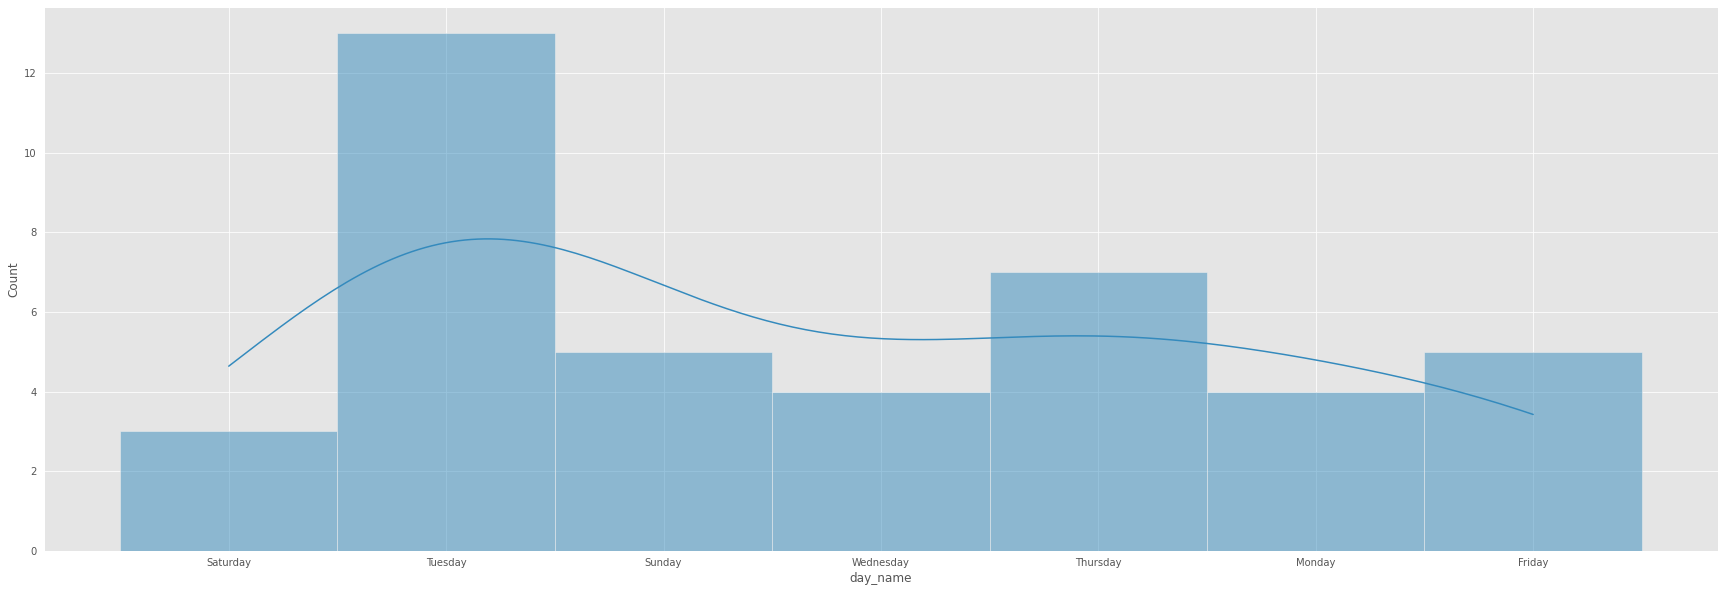

In [92]:
day_name_counts = df.day_name.value_counts(normalize=True)
sns.histplot(data=df, x="day_name", kde=True);

### Perguntas de interesse

- Qual foi a corrida mais longa em km? E em tempo?
- Qual foi a corrida com maior gasto calórico?
- Qual foi a corrida mais rápida (maior pace médio)?
- Como é minha performance por ambiente (velocidade, pace, calorias)?
- Como minha performance é afetada pela temperatura? E pelo clima?
- O horário do dia mostra alguma alteração nas métricas (melhora ou piora de performance)?

Também seria interessante ter uma visao de evolução das corridas, ao longo do tempo.
Ver quais são as tendências para as várias métricas.

## Data viz

In [17]:
def plot_time_series(x=None, y=None, title='title', xlabel=None, ylabel=None, label=''):
    plt.xticks(x)
    plt.plot(x, y, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    
def plot_barv(x=None, y=None, title='title', xlabel=None, ylabel=None, label=''):
    plt.bar(x, height=y, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)

### Categorical data

In [18]:
gb_day_name = df.groupby(by=['day_name']).agg({'sum', 'mean', 'max', 'min', p90})
gb_day_name.head()

/home/tuts/anaconda3/lib/python3.9/site-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


0        distance_total_KM                                            \
                       sum      mean        max        p90       min   
day_name                                                               
Friday           14.070067  2.814013   4.103880   3.918286  1.347184   
Monday            9.367815  2.341954   3.391853   3.372685  0.191853   
Saturday         20.948019  6.982673  11.153372   9.944611  4.685079   
Sunday           39.615188  7.923038  13.594162  12.686134  3.638666   
Thursday         31.802301  4.543186   8.822414   7.861592  0.689111   

0        nikefuel_total_FUEL                                         \
                         sum         mean          max          p90   
day_name                                                              
Friday           3419.815199   683.963040  1016.413013   937.318937   
Monday           2266.991354   566.747838   959.428604   881.517932   
Saturday         5128.427369  1709.475790  2813.362058  2517.697234   
Sunday           9817.819923  1963.563985  3263.628182  3150.940009   
Thursday         8256.778032  1179.539719  2316.775291  2078.599448   

0                    pace_mean_MKM                                            \
                 min           sum      mean        max        p90       min   
day_name                                                                       
Friday    346.461926     40.182758  8.036552   8.751978   8.678516  7.456497   
Monday     37.503823     37.918827  9.479707  10.997135  10.876622  8.132233   
Saturday  980.027373     26.962261  8.987420  13.162969  11.927019  6.816072   
Sunday    767.907156     38.792919  7.758584   9.083508   8.650579  7.008792   
Thursday  142.842340     55.258824  7.894118  11.809370  10.749818  6.175867   

0        steps_total_N                                  heart_rate_mean_BPM  \
                   sum     mean     max     p90     min                 sum   
day_name                                                                      
Friday         14733.0  2946.60  4115.0  4016.6  1393.0          757.333783   
Monday         10749.0  2687.25  4324.0  4115.8   233.0          419.912627   
Saturday       11555.0  5777.50  6630.0  6459.5  4925.0          145.445521   
Sunday          8011.0  4005.50  4018.0  4015.5  3993.0          143.779661   
Thursday        1768.0   884.00   925.0   916.8   843.0          219.556701   

0                                                        speed_mean_KMH  \
                mean         max         p90         min            sum   
day_name                                                                  
Friday    151.466757  162.363636  160.643660  134.928000      37.483232   
Monday    139.970876  155.523810  155.419888  109.384615      25.819236   
Saturday  145.445521  145.445521  145.445521  145.445521      21.952991   
Sunday    143.779661  143.779661  143.779661  143.779661      38.994023   
Thursday  109.778351  115.546392  114.392784  104.010309      56.099678   

0                                                nikefuel_mean_FUEL  \
              mean       max       p90       min                sum   
day_name                                                              
Friday    7.496646  8.046674  7.948750  6.855593         154.224921   
Monday    6.454809  7.378048  7.361354  5.455967         100.983144   
Saturday  7.317664  8.802724  8.760584  4.558242          90.346137   
Sunday    7.798805  8.560677  8.437633  6.605378         159.448461   
Thursday  8.014240  9.715235  9.459873  5.080711         234.740432   

0                                                    calories_total_KCAL  \
               mean        max        p90        min                 sum   
day_name                                                                   
Friday    30.844984  34.449426  34.002571  25.543792            1236.054   
Monday    25.245786  35.183341  33.194470  17.775728             790.066   
Saturday  30.115379  38.333216

In [19]:
gb_hour_of_the_day = df.groupby(by=['hour_of_the_day']).agg({'sum', 'mean', 'max', 'min', p90})
gb_hour_of_the_day.head()

0               distance_total_KM                                            \
                              sum      mean        max        p90       min   
hour_of_the_day                                                               
11                       6.651787  3.325893   3.391853   3.378661  3.259933   
14                       3.576777  3.576777   3.576777   3.576777  3.576777   
15                       4.685079  4.685079   4.685079   4.685079  4.685079   
16                       6.734412  6.734412   6.734412   6.734412  6.734412   
17                      45.325540  5.665693  11.153372  10.380079  1.347184   

0               nikefuel_total_FUEL                                         \
                                sum         mean          max          p90   
hour_of_the_day                                                              
11                      1518.404188   759.202094   818.677824   806.782678   
14                       893.926649   893.926649   893.926649   893.926649   
15                       980.027373   980.027373   980.027373   980.027373   
16                      1723.000606  1723.000606  1723.000606  1723.000606   
17                     11537.148204  1442.143526  2813.362058  2673.132874   

0                            pace_mean_MKM                                   \
                         min           sum       mean        max        p90   
hour_of_the_day                                                               
11                699.726364     19.347405   9.673702  10.595426  10.411081   
14                893.926649      7.094874   7.094874   7.094874   7.094874   
15                980.027373     13.162969  13.162969  13.162969  13.162969   
16               1723.000606      6.881781   6.881781   6.881781   6.881781   
17                346.461926     58.141915   7.267739   8.568322   8.263060   

0                          steps_total_N                                  \
                       min           sum    mean     max     p90     min   
hour_of_the_day                                                            
11                8.751978        7984.0  3992.0  4324.0  4257.6  3660.0   
14                7.094874        3434.0  3434.0  3434.0  3434.0  3434.0   
15               13.162969        6630.0  6630.0  6630.0  6630.0  6630.0   
16                6.881781           0.0     NaN     NaN     NaN     NaN   
17                5.950347        7824.0  2608.0  3869.0  3607.6  1393.0   

0               heart_rate_mean_BPM                                      \
                                sum        mean         max         p90   
hour_of_the_day                                                           
11                       162.363636  162.363636  162.363636  162.363636   
14                       163.032787  163.032787  163.032787  163.032787   
15                         0.000000         NaN         NaN         NaN   
16                         0.000000         NaN         NaN         NaN   
17                       439.969635  146.656545  155.004202  154.010848   

0                           speed_mean_KMH                                 \
                        min            sum      mean        max       p90   
hour_of_the_day                                                             
11               162.363636      12.518414  6.259207   6.855593  6.736316   
14               163.032787       8.456810  8.456810   8.456810  8.456810   
15                      NaN       4.558242  4.558242   4.558242  4.558242   
16                      NaN       8.718673  8.718673   8.718673  8.718673   
17               134.928000      66.839742  8.354968  10.083445  9.317934   

0                         nikefuel_mean_FUEL                                   \
                      min                sum       mean        max        p90   
hour_of_the_day                                                                 
11               5.662821          48.1

#### Distância por hora do dia

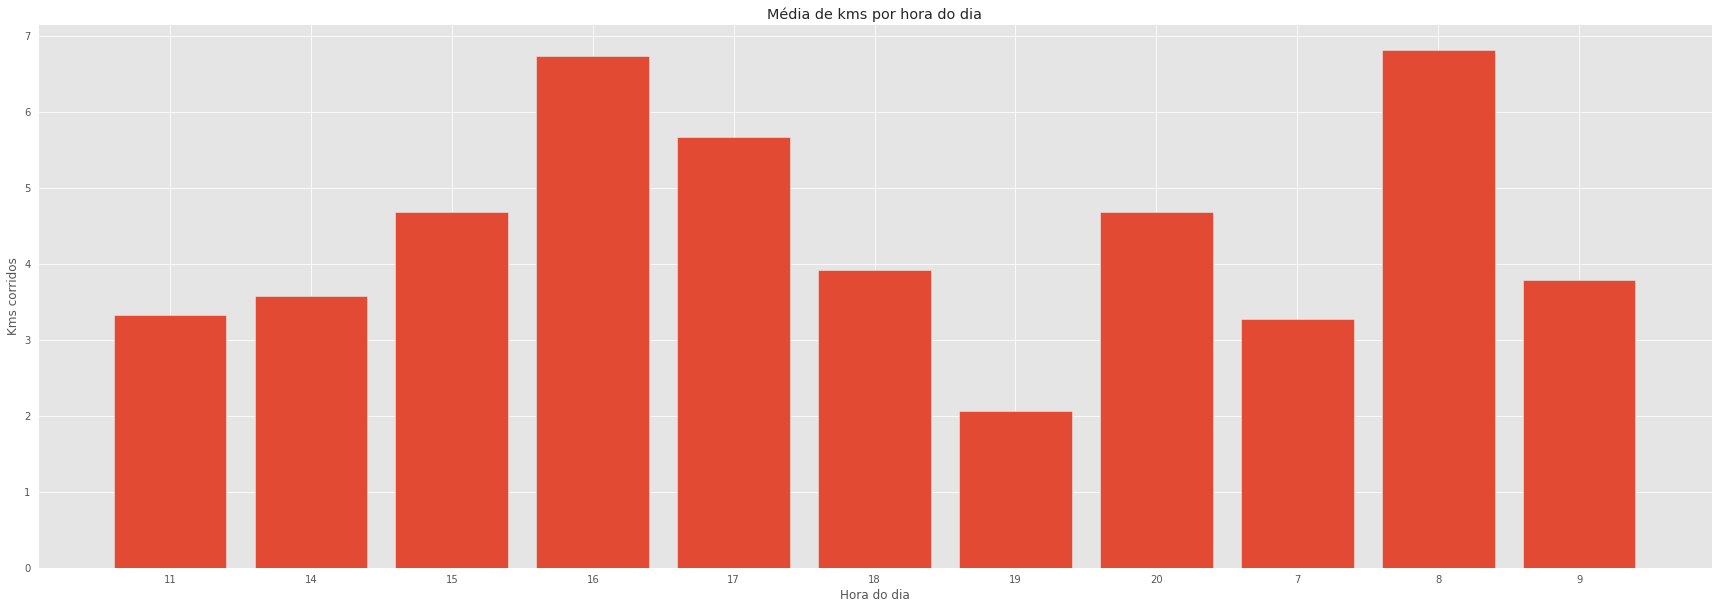

In [20]:
plot_barv(x=gb_hour_of_the_day.distance_total_KM['mean'].index, y=gb_hour_of_the_day.distance_total_KM['mean'].values, title='Média de kms por hora do dia', xlabel='Hora do dia', ylabel='Kms corridos');

#### Distância por dia da semana

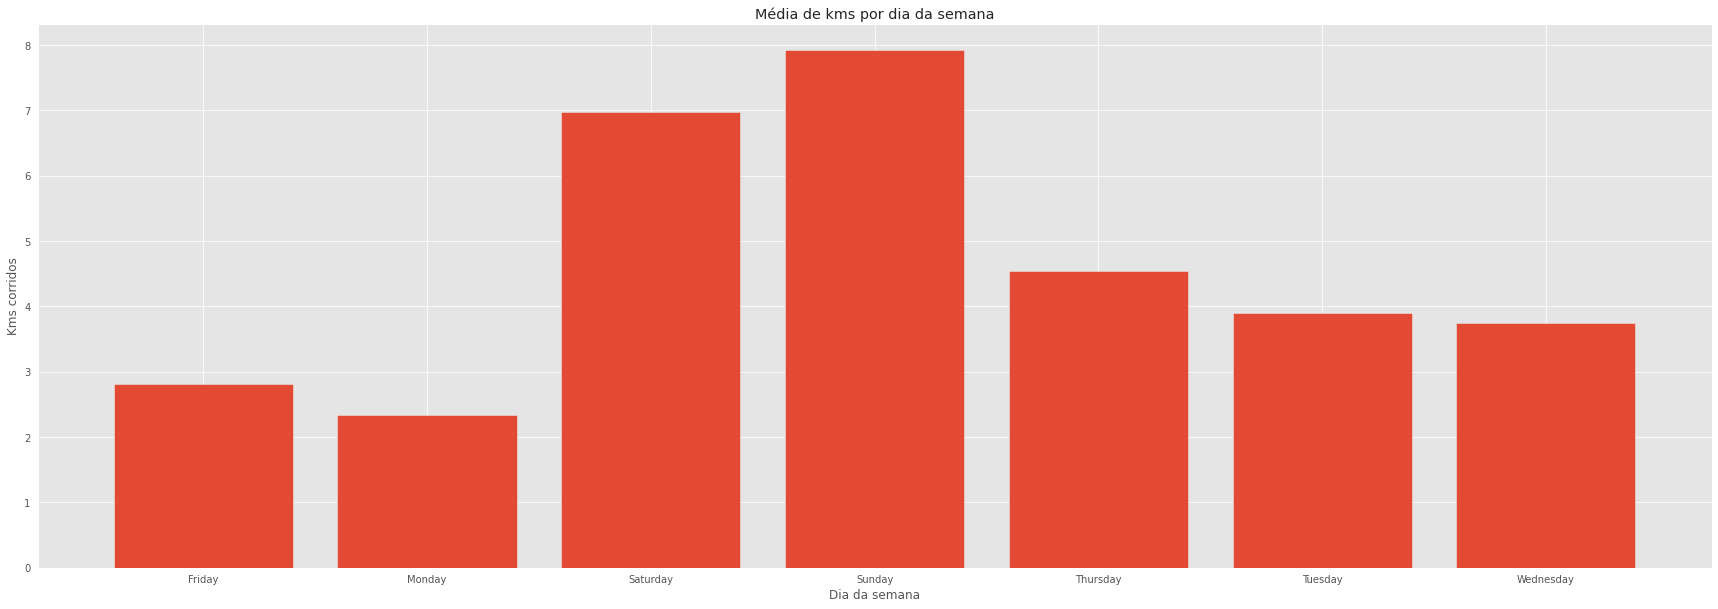

In [21]:
plot_barv(x=gb_day_name.distance_total_KM['mean'].index, y=gb_day_name.distance_total_KM['mean'].values, title='Média de kms por dia da semana', xlabel='Dia da semana', ylabel='Kms corridos');

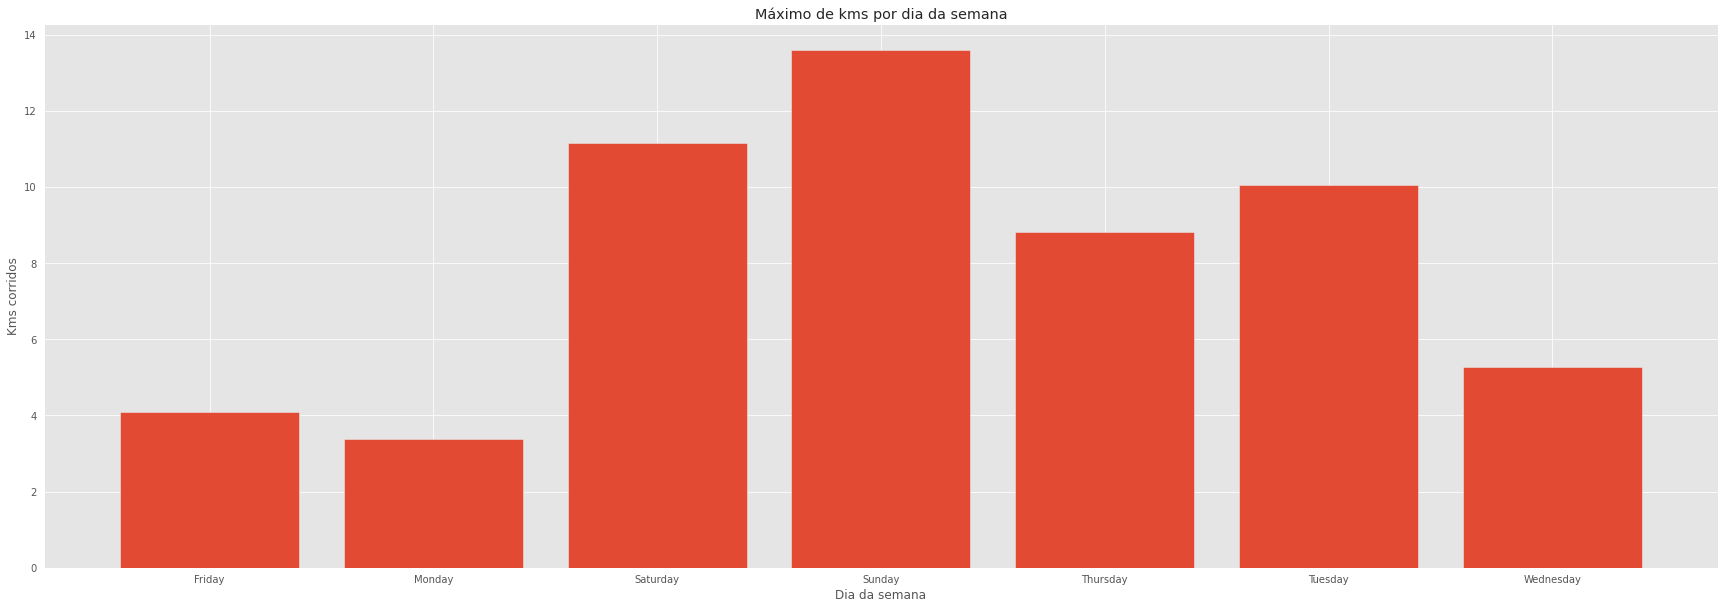

In [22]:
plot_barv(x=gb_day_name.distance_total_KM['max'].index, y=gb_day_name.distance_total_KM['max'].values, title='Máximo de kms por dia da semana', xlabel='Dia da semana', ylabel='Kms corridos');

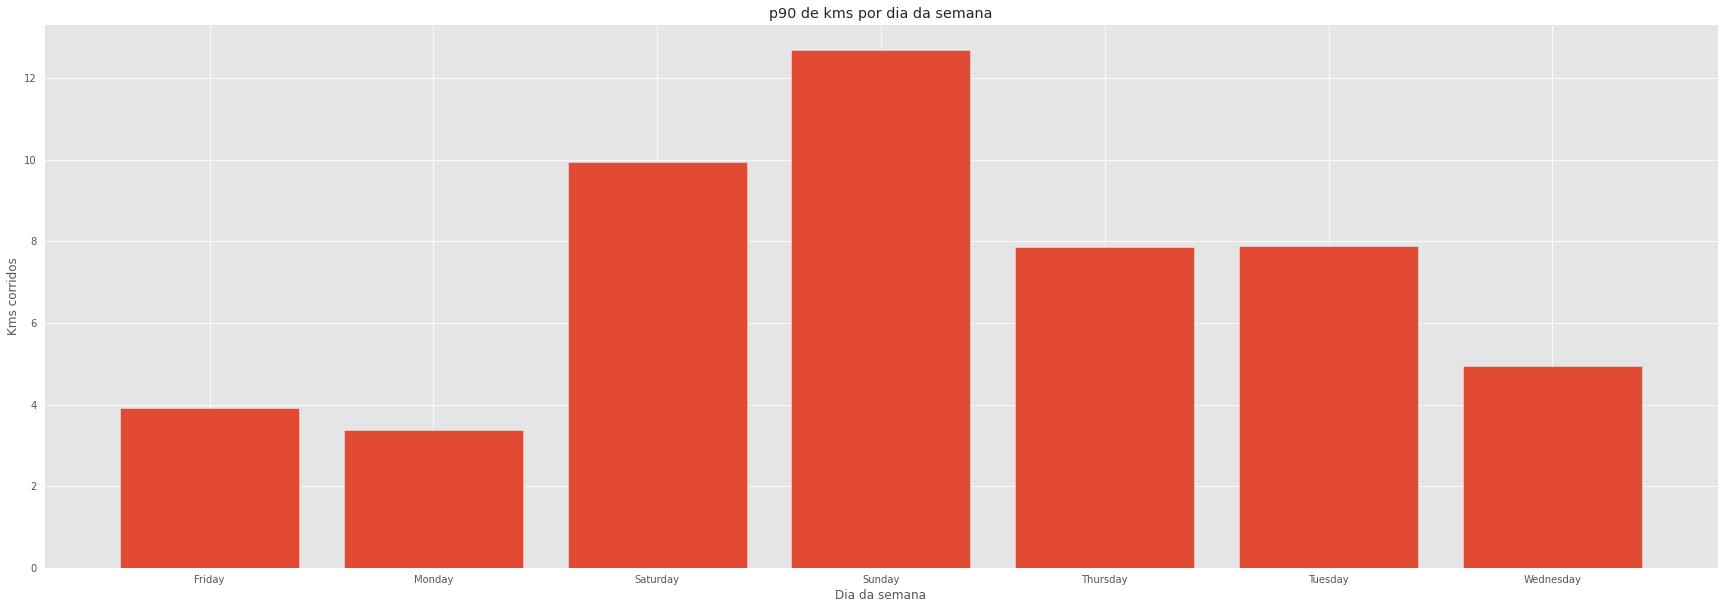

In [23]:
plot_barv(x=gb_day_name.distance_total_KM['p90'].index, y=gb_day_name.distance_total_KM['p90'].values, title='p90 de kms por dia da semana', xlabel='Dia da semana', ylabel='Kms corridos');

#### Pace por dia da semana

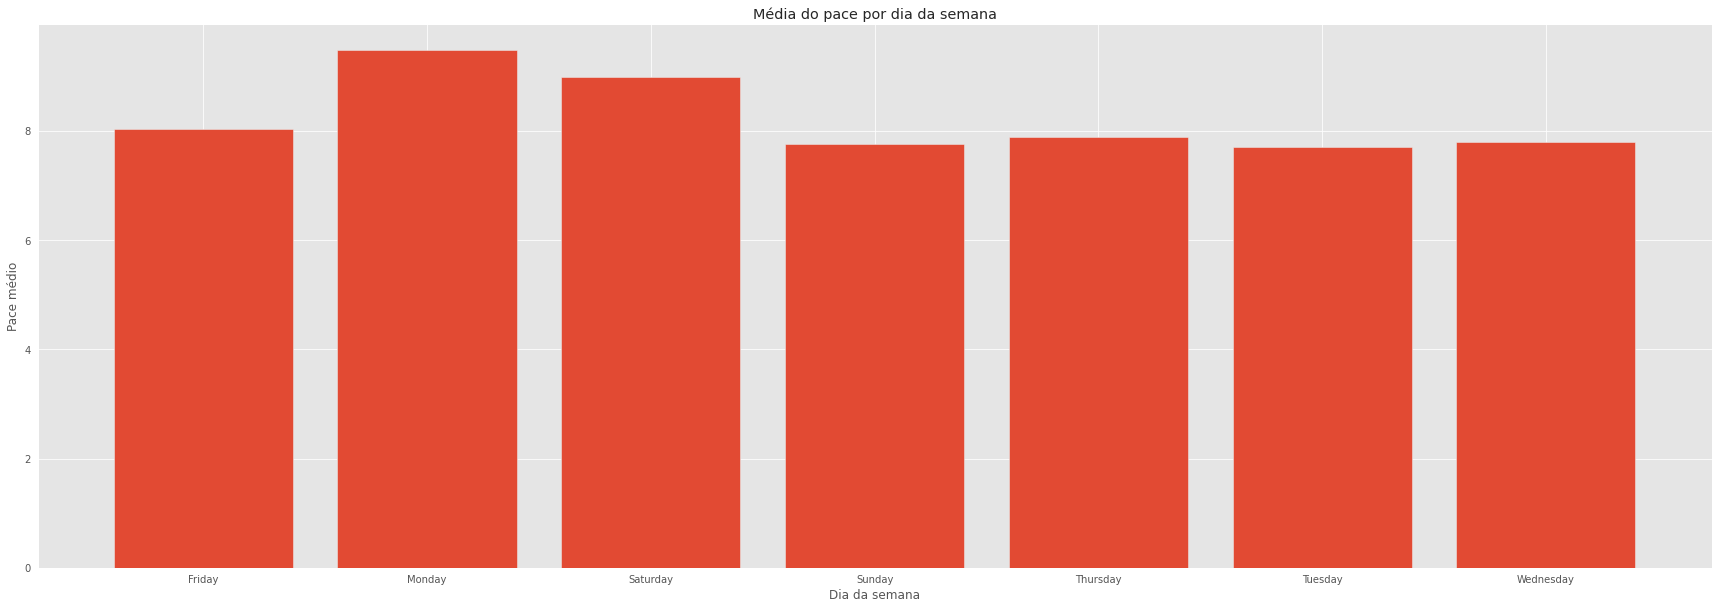

In [24]:
plot_barv(x=gb_day_name.pace_mean_MKM['mean'].index, y=gb_day_name.pace_mean_MKM['mean'].values, title='Média do pace por dia da semana', xlabel='Dia da semana', ylabel='Pace médio');

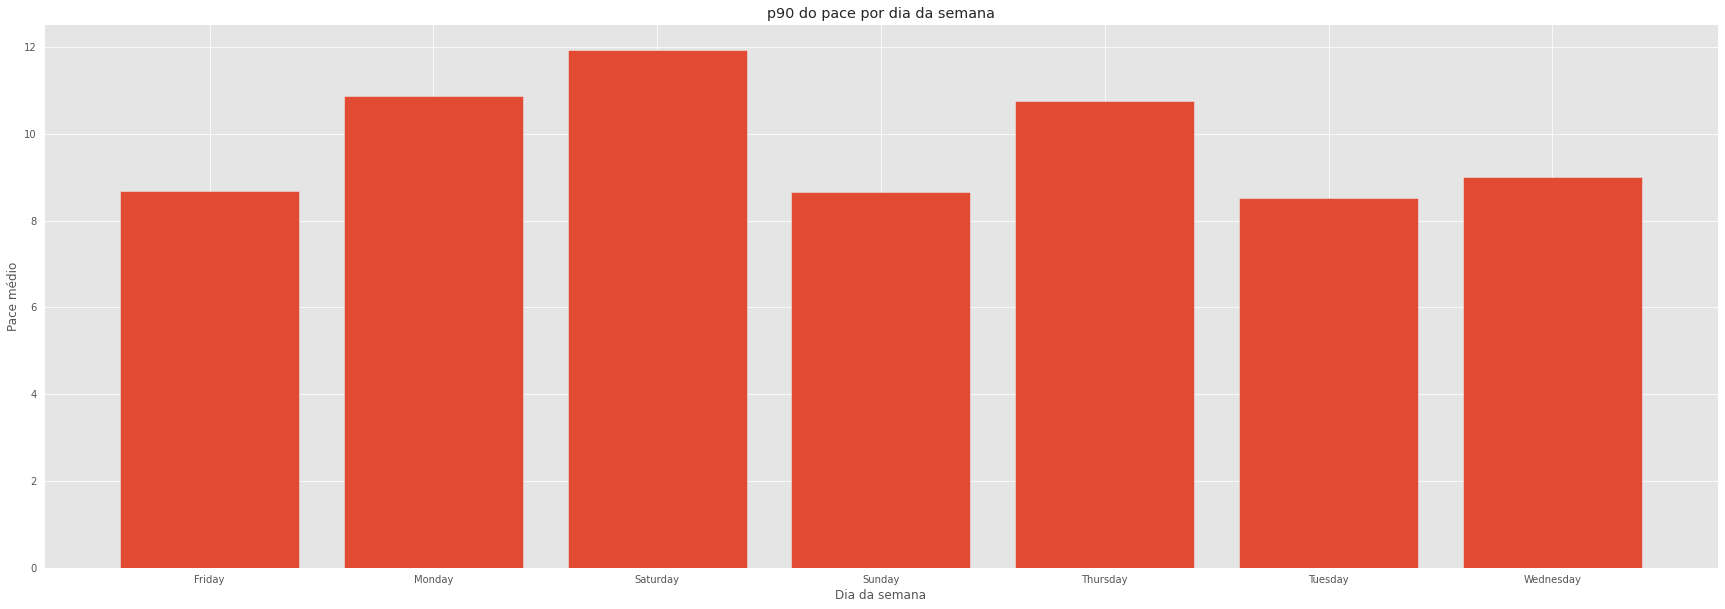

In [25]:
plot_barv(x=gb_day_name.pace_mean_MKM['p90'].index, y=gb_day_name.pace_mean_MKM['p90'].values, title='p90 do pace por dia da semana', xlabel='Dia da semana', ylabel='Pace médio');

### Time series

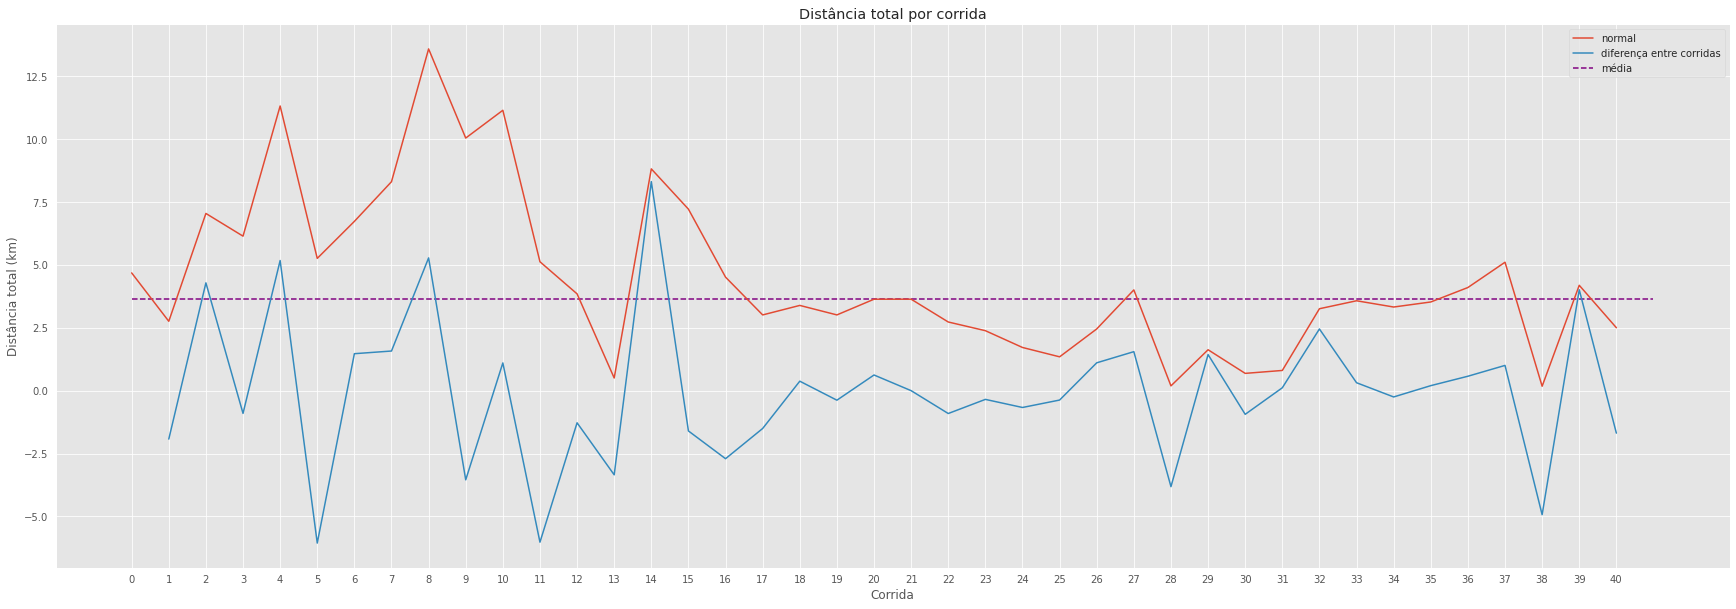

In [26]:
plot_time_series(x=range(len(df)), y=df.distance_total_KM, label='normal');
plt.hlines(df.distance_total_KM.median(), color='purple', linestyle='dashed', label='média', xmin=0, xmax=len(df))
plot_time_series(x=range(len(df)), y=df.distance_total_diff, title='Distância total por corrida', xlabel='Corrida', ylabel='Distância total (km)', label='diferença entre corridas');

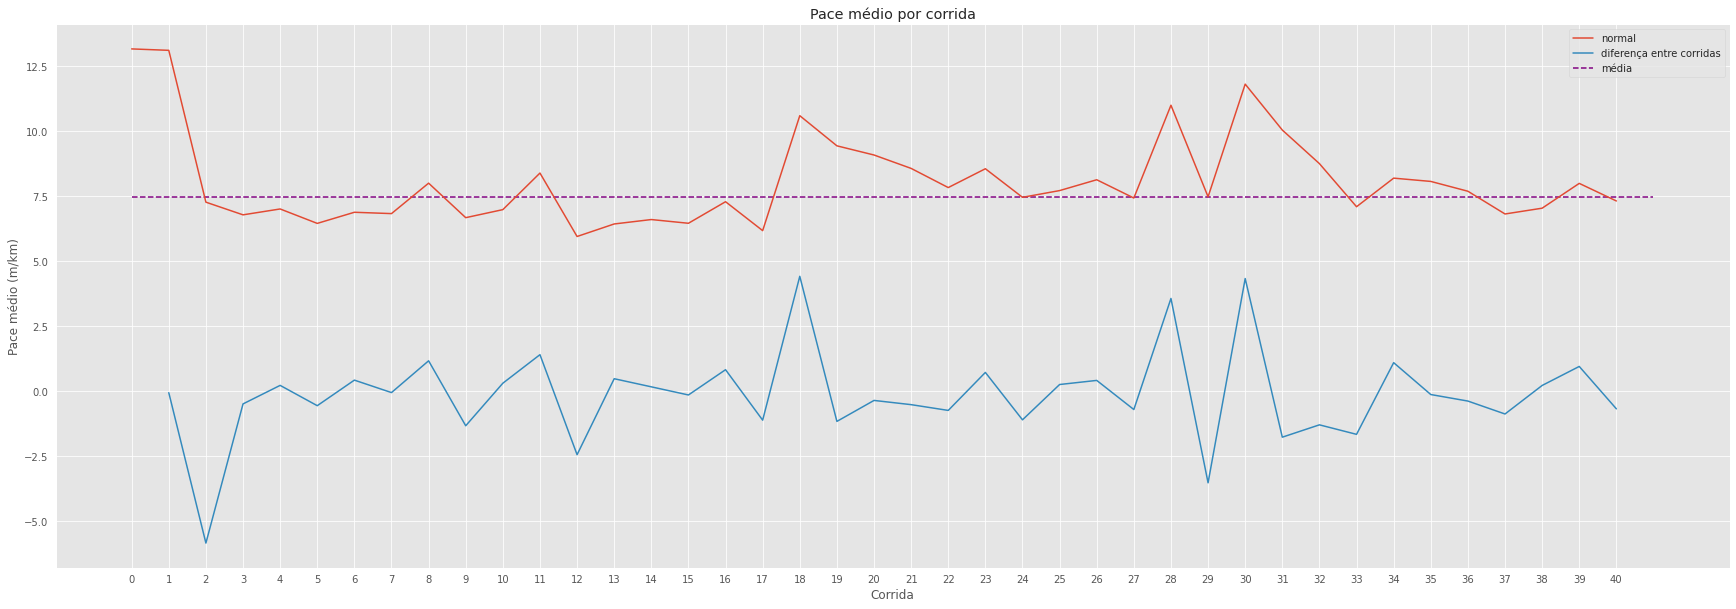

In [27]:
plot_time_series(x=range(len(df)), y=df.pace_mean_MKM, label='normal');
plt.hlines(df.pace_mean_MKM.median(), color='purple', linestyle='dashed', label='média', xmin=0, xmax=len(df))
plot_time_series(x=range(len(df)), y=df.pace_mean_MKM.diff(), title='Pace médio por corrida', xlabel='Corrida', ylabel='Pace médio (m/km)', label='diferença entre corridas');

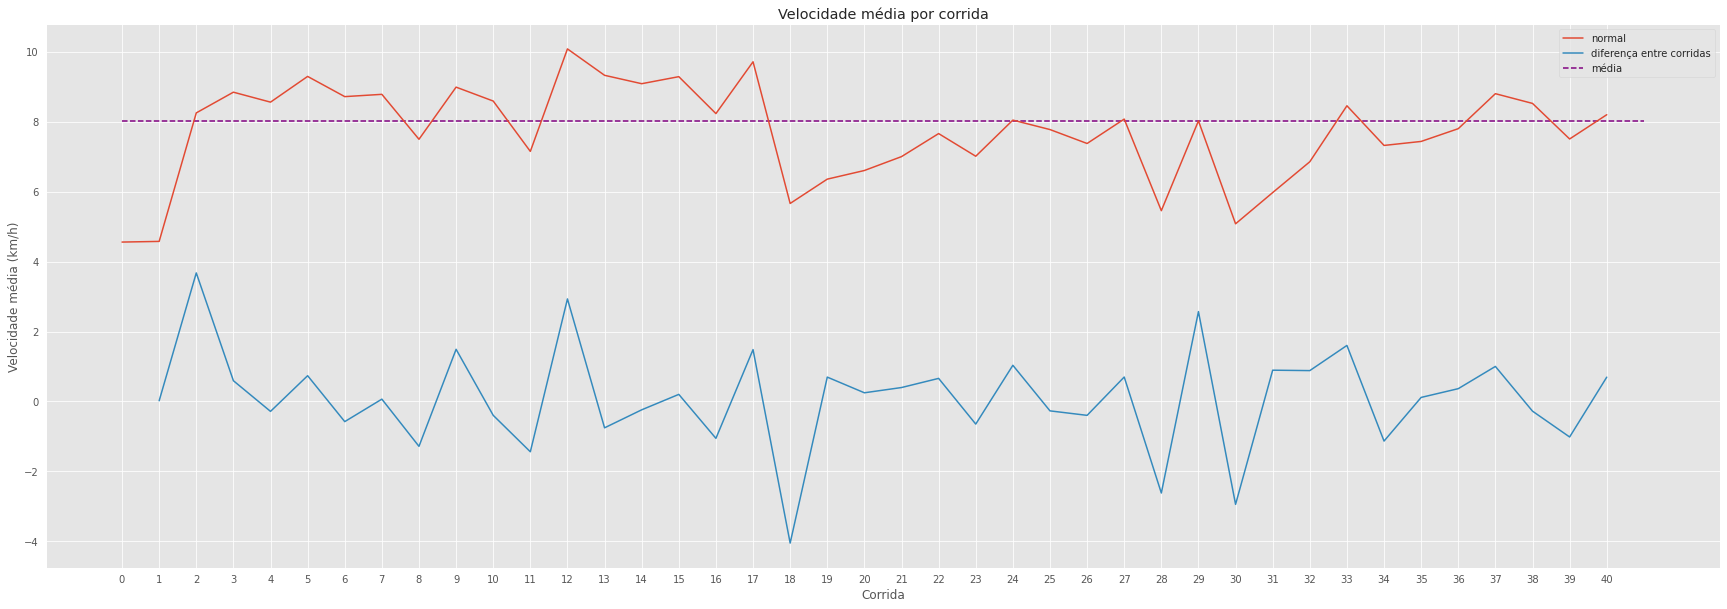

In [28]:
plot_time_series(x=range(len(df)), y=df.speed_mean_KMH, label='normal');
plt.hlines(df.speed_mean_KMH.median(), color='purple', linestyle='dashed', label='média', xmin=0, xmax=len(df))
plot_time_series(x=range(len(df)), y=df.speed_mean_KMH.diff(), title='Velocidade média por corrida', xlabel='Corrida', ylabel='Velocidade média (km/h)', label='diferença entre corridas');

### Diferença em dias sem correr vs pace médio (p90 dos dias sem correr porque fiquei um período longo sem corridas)

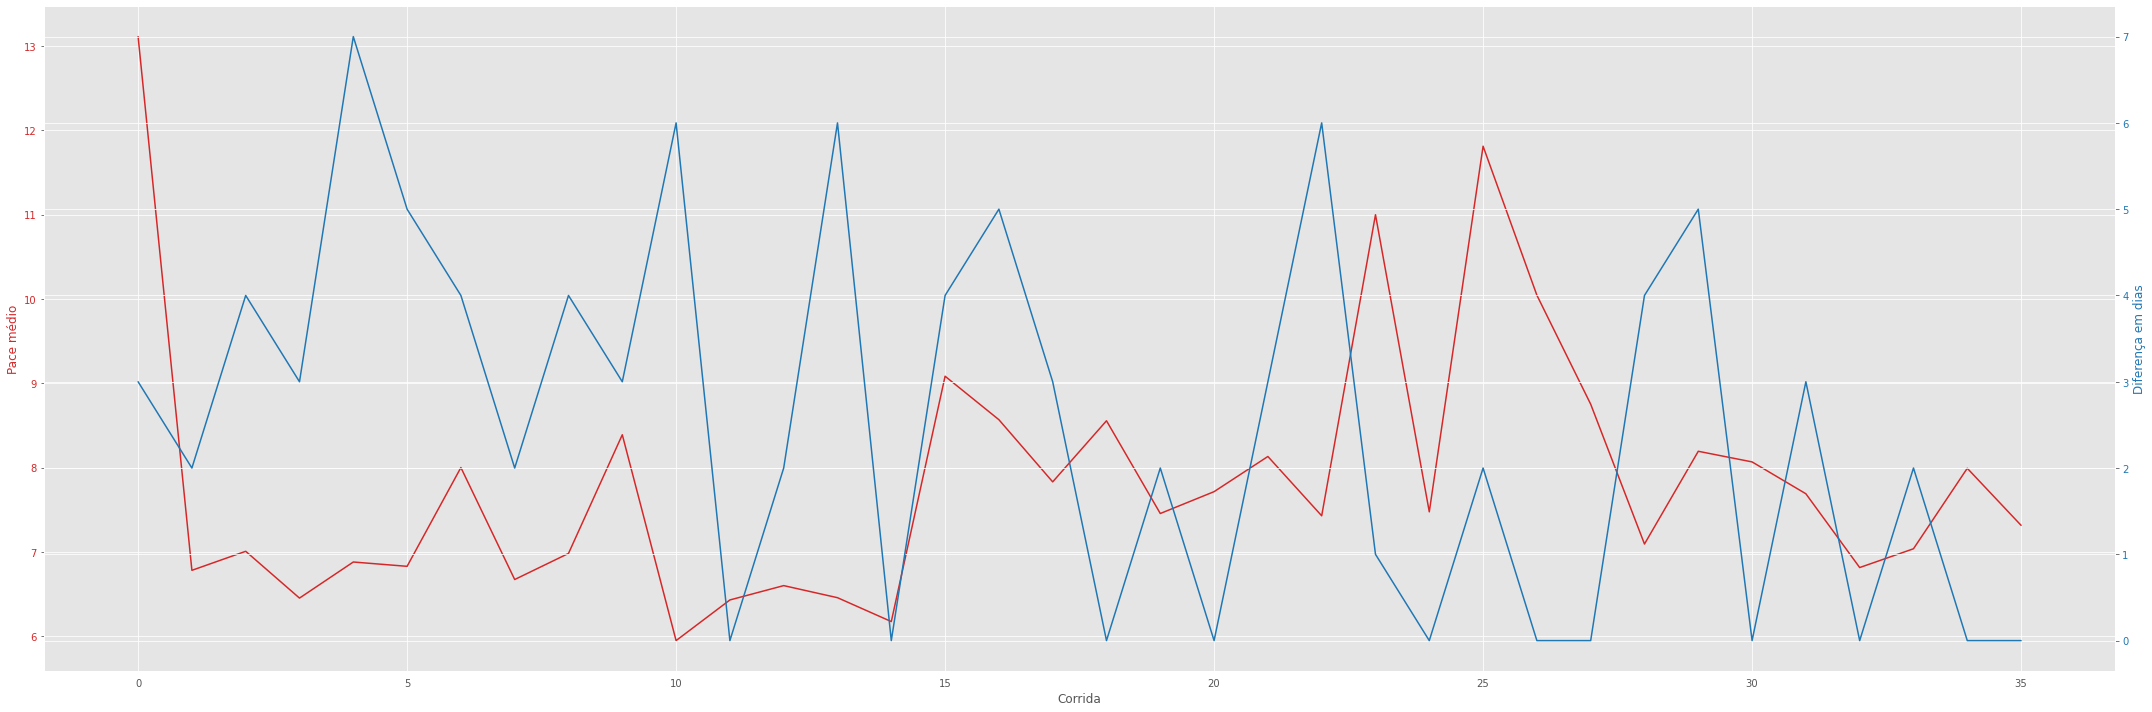

In [49]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Corrida')
ax1.set_ylabel('Pace médio', color=color)
ax1.plot(range(len(days_diff_below_p90)), days_diff_below_p90.pace_mean_MKM, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Diferença em dias', color=color)  # we already handled the x-label with ax1
ax2.plot(range(len(days_diff_below_p90)), days_diff_below_p90.days_diff, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()